In [44]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys

sys.path.append("../../src")

# custom
# from src.utils.plotting import format_geo_axes

boundary_dir_fp = Path(
    "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/iccs_hackathon/data/boundaries"
)

region_df = pd.read_excel(boundary_dir_fp / "Region Delineation.xlsx")


CS_REGION = "waus"
# get Western Autralia region
CS_LATS = (
    min(region_df[region_df["region"] == "waus"]["lats"]),
    max(region_df[region_df["region"] == "waus"]["lats"]),
)
CS_LONS = (
    min(region_df[region_df["region"] == "waus"]["lons"]),
    max(region_df[region_df["region"] == "waus"]["lons"]),
)


region_df.head()

,region,west,lons,lats
0,spac,-185.0,175.0,-5.0
1,spac,-175.0,-175.0,-10.0
2,spac,-150.0,-150.0,-10.0
3,spac,-140.0,-140.0,-5.0
4,spac,-105.0,-105.0,-25.0


In [45]:
from shapely.geometry import Polygon


# Build polygons for each region
def build_polygon(group):
    # Extract the coordinates as tuples
    coords = list(zip(group["lons"], group["lats"]))
    return Polygon(coords)


# Apply groupby and build polygons
polygons = region_df.groupby("region").apply(build_polygon)

# Create a new dataframe
df_polygons = polygons.reset_index(name="geometry")

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_59215/2969900992.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  polygons = region_df.groupby("region").apply(build_polygon)


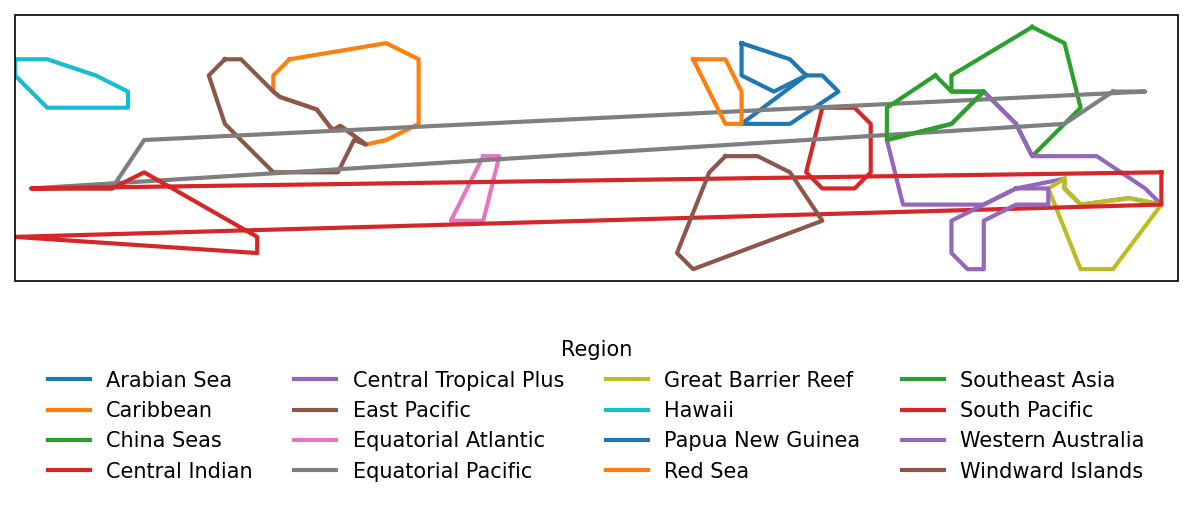

In [46]:
fig, ax = plt.subplots(
    figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=150
)

# format_geo_axes(ax)

REGION_MAP = {
    "arab": "Arabian Sea",  # arab
    "car": "Caribbean",  # car
    "china": "China Seas",  # china
    "cind": "Central Indian",  # cind
    "ctplus": "Central Tropical Plus",  # ctplus
    "enso": "ENSO",  # enso
    "enso1+2": "ENSO 1+2",  # enso1+2
    "enso3": "ENSO 3",  # enso3
    "enso4": "ENSO 4",  # enso4
    "epac": "East Pacific",  # epac
    "eqatl": "Equatorial Atlantic",  # eqatl
    "eqpac": "Equatorial Pacific",  # eqpac
    "gbr": "Great Barrier Reef",  # gbr
    "hi": "Hawaii",  # hi
    "pg": "Papua New Guinea",  # pg
    "red": "Red Sea",  # red
    "sea": "Southeast Asia",  # sea
    "spac": "South Pacific",  # spac
    "waus": "Western Australia",  # waus
    "wind": "Windward Islands",  # wind
}

# exclude ENSO regions
df_polygons = df_polygons[
    ~df_polygons["region"].isin(["enso", "enso1+2", "enso3", "enso4"])
]


for idx, row in df_polygons.iterrows():
    poly = row["geometry"]
    region = row["region"]  # Adjust if your region column has a different name
    if poly is not None and hasattr(poly, "exterior"):
        x, y = poly.exterior.xy
        ax.plot(x, y, linewidth=2, label=REGION_MAP[region])


# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# Place the legend below the axis, centered, with multiple columns
ax.legend(
    by_label.values(),
    by_label.keys(),
    title="Region",
    ncols=len(by_label) // 4,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),  # 0.5 = center, -0.15 = below the axis
    frameon=False,
)

plt.show()


In [ ]:
# zoom into case study region
fig, ax = plt.subplots(
    figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300
)
# format_geo_axes(ax, extent=(*CS_LONS, *CS_LATS))


In [ ]:
# download SST data
from src.data import dataloader

dataloader.download_erdapp_thredds_nc_files(
    var="CRW_SST",
    date_range=("1985-04-01T12:00:00Z", "2024-04-28T12:00:00Z"),
    lats=CS_LONS,
    lons=CS_LATS,
    output_dir=Path(config.sst_dir) / "CRW_SST",
)